In [15]:
import pandas as pd
import sqlite3
import numpy as np
from plotnine import *

# Connect to Database and Extract Dataset

In [16]:
conn = sqlite3.connect("sabs_moonshot.db")
data = pd.read_sql_query("""
SELECT smiles, fingerprint, r_avg_IC50, f_avg_IC50
FROM assays
INNER JOIN compounds ON compounds.id = assays.compound_id
WHERE assays.r_avg_IC50 != "" OR assays.f_avg_IC50 != "";
""", conn)
pd.to_numeric(data["r_avg_IC50"], errors='coerce')
pd.to_numeric(data["f_avg_IC50"], errors='coerce')
data["r_avg_IC50"] = data["r_avg_IC50"].replace("", np.NaN)
data["f_avg_IC50"] = data["f_avg_IC50"].replace("", np.NaN)
conn.close()
data = data[data["f_avg_IC50"] < 99]
data = data[data["r_avg_IC50"] < 99]
data

,smiles,fingerprint,r_avg_IC50,f_avg_IC50
2,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,0000000000000000000000000000000000000000010000...,14.641091,26.680129
3,O=C(Cc1cncc2ccccc12)Nc1ccccc1,0000000000000000000000000000000000000000010000...,45.077469,57.469670
5,Cc1c(N)cncc1NC(=O)Cc1cccc(Cl)c1,0000000000000000000000000000000000000000010000...,8.201698,4.222340
6,Cc1ccncc1NC(=O)Cc1cccc(Cl)c1,0000000000000000000000000000000000000000010000...,13.895165,24.566619
7,Cc1ccncc1NC(=O)Nc1cccc(Cl)c1,0000000000000000000000000000000000000000000000...,45.689263,64.413611
...,...,...,...,...
1616,Cc1ccc(C)c(S(=O)(=O)N2CCN(C(=O)CCl)CC2)c1,0000000000000000000000000000000000000000000000...,1.623369,14.216485
1637,O=C(Nc1cncc2ccccc12)C1CCOc2cc(Cl)c(Cl)cc21,0000000000000000000000000000000000000000000000...,0.309337,0.205428
1711,O=C(CCl)N1CCN(Cc2cccc(Cl)c2)CC1,0000000000000000000000000000000000000000000000...,0.545448,2.536267
1802,O=C(CCl)N1CCN(S(=O)(=O)c2cccc(F)c2)CC1,0000000000000000000000000000000000000000000000...,2.023561,3.666429


## Create X, Y Inputs and Outputs numpy arrays

In [17]:
X = np.array([[int(c) for c in data["fingerprint"].iloc[i]] for i in range(len(data["fingerprint"]))])
Y = -np.log10(np.mean(data[["r_avg_IC50", "f_avg_IC50"]], axis=1).to_numpy())

# Perform Feature Selection

### Remove Low Variance Features

In [18]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold = 0)
X = sel.fit_transform(X)
X.shape

(424, 1322)

### Remove Highly Correlated Features

In [19]:
X = pd.DataFrame(X)
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X.drop(to_drop, axis=1, inplace=True)
X = X.to_numpy()
X.shape


(424, 986)

### Final Datasets X and Y

In [20]:
X, Y # X is features, Y is avg IC50
np.save("regressor_data/X", X)
np.save("regressor_data/Y", Y)

/usr/local/anaconda3.7/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 11'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


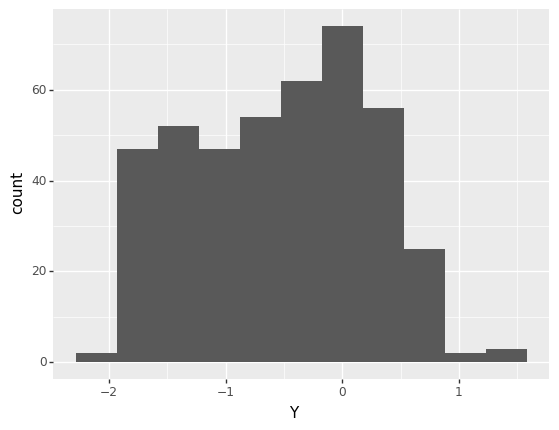

<ggplot: (8777900097401)>

In [21]:
(
    ggplot(pd.DataFrame(X, Y)) +
    geom_histogram(aes(x='Y'))
)